In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim


# Define a function to project weights to a simplex
def project_to_simplex(weights):
    return torch.clamp(weights, min=0) / torch.sum(weights)

def project_simplex(v):
        """
        v: PyTorch Tensor to be projected to a simplex

        Returns:
        w: PyTorch Tensor simplex projection of v
        """
        z = 1
        orig_shape = v.shape
        v = v.view(1, -1)
        shape = v.shape
        with torch.no_grad():
            mu = torch.sort(v, dim=1)[0]
            mu = torch.flip(mu, dims=(1,))
            cum_sum = torch.cumsum(mu, dim=1)
            j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
            rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
            rho = rho.to(int)
            max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
            theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
            w = torch.clamp(v - theta, min=0.0).view(orig_shape)
            return w
        
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)
subset = torch.utils.data.Subset(cifar_trainset, range(42000))
unlabeled, target = torch.utils.data.random_split(subset, [40000, 2000])

# Filter target dataset to include only one label, e.g., 0
target_images, target_labels = zip(*target)
label_to_keep = 9
print("Target Label:{}".format(label_to_keep))
filtered_target_indices = [i for i, label in enumerate(target_labels) if label == label_to_keep]
target_images_org = [target_images[i] for i in filtered_target_indices]
target_images = torch.stack(target_images_org)
print("No of target images:{}".format(target_images.shape[0]))

unlabeled_images, unlabeled_labels = zip(*unlabeled)
unlabeled_images = torch.stack(unlabeled_images)
unlabeled_loader = DataLoader(list(zip(unlabeled_images, unlabeled_labels)), batch_size=4000, shuffle=False)

target_loader = DataLoader(target_images, batch_size=len(target_images), shuffle=False)

# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images
weights_unlabeled = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_target = torch.full((len(target_images), 1), 1.0 / len(target), requires_grad=False)

# Define an optimizer
#optimizer = optim.SGD([weights_unlabeled], lr=0.001)
optimizer = optim.Adam([weights_unlabeled], lr=0.01)

# Loop over the datasets 10 times
for epoch in range(10):

    losses = []
    weights_unlabeled.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, ((unlabeled_images, _),target_images) in enumerate(zip(unlabeled_loader, target_loader)):
        optimizer.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        weights_batch = weights_unlabeled[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch = weights_batch.clone() / weights_batch.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)


        # Compute Sinkhorn loss
        loss = sinkhorn_loss(weights_batch,unlabeled_images.view(unlabeled_images.shape[0], -1), weights_target,
                             target_images.view(target_images.shape[0], -1),
                             )

        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)

    # Update the weights based on the accumulated gradients
    optimizer.step()

    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled.data = project_simplex(weights_unlabeled.data)
    
    #weights_unlabeled = weights_unlabeled_new.clone().detach().requires_grad_(True)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

# Sort the weights in descending order and print the non-zero weights
sorted_weights, indices = torch.sort(weights_unlabeled.flatten(), descending=True)
top_weights = sorted_weights[:10]
top_indices = indices[:10]

# Retrieve the labels of the images corresponding to the top indices
top_labels = [unlabeled_labels[idx] for idx in top_indices]

print("Top 10 weights, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights, top_indices, top_labels):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")

In [ ]:
!pip install matplotlib

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w
        
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)
subset = torch.utils.data.Subset(cifar_trainset, range(50000))
unlabeled, remaining = torch.utils.data.random_split(subset, [40000, 10000])

# split remaining into target and private
target, private = torch.utils.data.random_split(remaining, [5000, 5000])

# Filter target dataset to include only one label, e.g., 0
target_images, target_labels = zip(*target)
label_to_keep = 9
print("Target Label:{}".format(label_to_keep))
filtered_target_indices = [i for i, label in enumerate(target_labels) if label == label_to_keep]
target_images_org = [target_images[i] for i in filtered_target_indices]
target_images = torch.stack(target_images_org)
print("No of target and private images:{}".format(target_images.shape[0]))

unlabeled_images, unlabeled_labels = zip(*unlabeled)
unlabeled_images = torch.stack(unlabeled_images)
unlabeled_loader = DataLoader(list(zip(unlabeled_images, unlabeled_labels)), batch_size=2000, shuffle=False)

target_loader = DataLoader(target_images, batch_size=len(target_images), shuffle=False)

# Filter private dataset to exclude label_to_keep
private_images, private_labels = zip(*private)
filtered_private_indices = [i for i, label in enumerate(private_labels) if label != label_to_keep]
private_images_org = [private_images[i] for i in filtered_private_indices]
private_images = torch.stack(private_images_org[:len(target_images)])

private_loader = DataLoader(private_images, batch_size=len(private_images), shuffle=False)

# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images and private_images
weights_unlabeled = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_target = torch.full((len(target_images), 1), 1.0 / len(target), requires_grad=False)
weights_private = torch.full((len(private_images), 1), 1.0 / len(private), requires_grad=False)

# Define an optimizer
optimizer = optim.Adam([weights_unlabeled], lr=0.1)

# Loop over the datasets 10 times
for epoch in range(100):

    losses = []
    weights_unlabeled.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, ((unlabeled_images, _), target_images, private_images) in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        optimizer.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch = weights_unlabeled[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch = weights_batch.clone() / weights_batch.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch, unlabeled_images, weights_private, private_images)
        loss_private_target = sinkhorn_loss(weights_private, private_images, weights_target, target_images)

        loss = loss_unlabeled_target + loss_unlabeled_private # - loss_private_target

        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)

    # Update the weights based on the accumulated gradients
    optimizer.step()

    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled.data = project_simplex(weights_unlabeled.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

# Sort the weights in descending order and print the non-zero weights
sorted_weights, indices = torch.sort(weights_unlabeled.flatten(), descending=True)
top_weights = sorted_weights[:10]
top_indices = indices[:10]

# Retrieve the labels of the images corresponding to the top indices
top_labels = [unlabeled_labels[idx] for idx in top_indices]

print("Top 10 weights, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights, top_indices, top_labels):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")


In [ ]:
top_weights = sorted_weights[:40]
top_indices = indices[:40]

# Retrieve the labels of the images corresponding to the top indices
top_labels = [unlabeled_labels[idx] for idx in top_indices]

print("Top 10 weights, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights, top_indices, top_labels):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w

transform = transforms.Compose(
    [
     #conver to grayscale,
    transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)
subset = torch.utils.data.Subset(cifar_trainset, range(10000))
unlabeled, remaining = torch.utils.data.random_split(subset, [4000, 6000])

# split remaining into target and private
target, private = torch.utils.data.random_split(remaining, [3000, 3000])

# Filter target dataset to include only one label, e.g., 0
target_images, target_labels = zip(*target)
label_to_keep = 9
print("Target Label:{}".format(label_to_keep))
filtered_target_indices = [i for i, label in enumerate(target_labels) if label == label_to_keep]
target_images_org = [target_images[i] for i in filtered_target_indices]
target_images = torch.stack(target_images_org)
print("No of target and private images:{}".format(target_images.shape[0]))

unlabeled_images, unlabeled_labels = zip(*unlabeled)
unlabeled_images = torch.stack(unlabeled_images)
unlabeled_loader = DataLoader(list(zip(unlabeled_images, unlabeled_labels)), batch_size=4000, shuffle=False)

target_loader = DataLoader(target_images, batch_size=len(target_images), shuffle=False)

# Filter private dataset to exclude label_to_keep
private_images, private_labels = zip(*private)
filtered_private_indices = [i for i, label in enumerate(private_labels) if label != label_to_keep]
private_images_org = [private_images[i] for i in filtered_private_indices]
private_images = torch.stack(private_images_org[:len(target_images)])

private_loader = DataLoader(private_images, batch_size=len(private_images), shuffle=False)

# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images for target and private
weights_unlabeled_target = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_unlabeled_private = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_target = torch.full((len(target_images), 1), 1.0 / len(target), requires_grad=False)
weights_private = torch.full((len(private_images), 1), 1.0 / len(private), requires_grad=False)

# Define an optimizer for each set of weights
optimizer_target = optim.Adam([weights_unlabeled_target], lr=.1)
optimizer_private = optim.Adam([weights_unlabeled_private], lr=.1)

# Define the learning rate scheduler
scheduler_target = torch.optim.lr_scheduler.StepLR(optimizer_target, step_size=10, gamma=0.1)
scheduler_private = torch.optim.lr_scheduler.StepLR(optimizer_private, step_size=10, gamma=0.1)

# Loop over the datasets 10 times
for epoch in range(100):

    losses = []
    weights_unlabeled_target.grad = None  # Reset gradients at the beginning of each epoch
    weights_unlabeled_private.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, ((unlabeled_images, _), target_images, private_images) in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        optimizer_target.zero_grad()  # Reset gradients
        optimizer_private.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch_target = weights_unlabeled_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_target = weights_batch_target.clone() / weights_batch_target.sum()
        weights_batch_private = weights_unlabeled_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_private = weights_batch_private.clone() / weights_batch_private.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_images, weights_private, private_images)
        loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_batch_private, unlabeled_images)

        loss = loss_unlabeled_target + loss_unlabeled_private - loss_private_target
        print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}, Loss private-target: {loss_private_target.item()}")
        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

        
       
    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)
   
    # Update the weights based on the accumulated gradients
    optimizer_target.step()
    optimizer_private.step()

    # Step the learning rate scheduler
    scheduler_target.step()
    scheduler_private.step()
    
   
    
    


    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled_target.data = project_simplex(weights_unlabeled_target.data)
        weights_unlabeled_private.data = project_simplex(weights_unlabeled_private.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

    # Sort the weights in descending order and print the non-zero weights
    sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
    top_weights_target = sorted_weights_target[:10]
    top_indices_target = indices_target[:10]

    sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
    top_weights_private = sorted_weights_private[:10]
    top_indices_private = indices_private[:10]

    # Retrieve the labels of the images corresponding to the top indices
    top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
    top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

    print("Top 10 weights for target, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

    print("Top 10 weights for private, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")


# Masking gradients

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)
subset = torch.utils.data.Subset(cifar_trainset, range(42000))
unlabeled, remaining = torch.utils.data.random_split(subset, [40000, 2000])

# split remaining into target and private
target, private = torch.utils.data.random_split(remaining, [1000, 1000])

# Filter target dataset to include only one label, e.g., 0
target_images, target_labels = zip(*target)
label_to_keep = 9
print("Target Label:{}".format(label_to_keep))
filtered_target_indices = [i for i, label in enumerate(target_labels) if label == label_to_keep]
target_images_org = [target_images[i] for i in filtered_target_indices]
target_images = torch.stack(target_images_org)
print("No of target and private images:{}".format(target_images.shape[0]))

unlabeled_images, unlabeled_labels = zip(*unlabeled)
unlabeled_images = torch.stack(unlabeled_images)
unlabeled_loader = DataLoader(list(zip(unlabeled_images, unlabeled_labels)), batch_size=4000, shuffle=False)

target_loader = DataLoader(target_images, batch_size=len(target_images), shuffle=False)

# Filter private dataset to exclude label_to_keep
private_images, private_labels = zip(*private)
filtered_private_indices = [i for i, label in enumerate(private_labels) if label != label_to_keep]
private_images_org = [private_images[i] for i in filtered_private_indices]
private_images = torch.stack(private_images_org[:len(target_images)])

private_loader = DataLoader(private_images, batch_size=len(private_images), shuffle=False)

# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images for target and private
weights_unlabeled_target = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_unlabeled_private = torch.full((len(unlabeled), 1), 1.0 / len(unlabeled), requires_grad=True)
weights_target = torch.full((len(target_images), 1), 1.0 / len(target), requires_grad=False)
weights_private = torch.full((len(private_images), 1), 1.0 / len(private), requires_grad=False)

# Define an optimizer for each set of weights
optimizer_target = optim.SGD([weights_unlabeled_target,weights_unlabeled_private], lr=0.01)
#optimizer_private = optim.Adam([weights_unlabeled_private], lr=0.01)

# Loop over the datasets 10 times
for epoch in range(100):

    losses = []
    weights_unlabeled_target.grad = None  # Reset gradients at the beginning of each epoch
    weights_unlabeled_private.grad = None  # Reset gradients at the beginning of each epoch

    for batch_idx, ((unlabeled_images, _), target_images, private_images) in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        optimizer_target.zero_grad()  # Reset gradients
        

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch_target = weights_unlabeled_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_target = weights_batch_target.clone() / weights_batch_target.sum()
        weights_batch_private = weights_unlabeled_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_private = weights_batch_private.clone() / weights_batch_private.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_images, weights_private, private_images)
        #loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_batch_private, unlabeled_images)

        loss = loss_unlabeled_target + loss_unlabeled_private #- loss_private_target
        #print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}, Loss private-target: {loss_private_target.item()}")
        print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}")
        losses.append(loss.item())

        # Compute gradients for the loss
        loss.backward()  # Gradients are accumulated over mini-batches

        # Create a mask for weights_unlabeled_target and weights_unlabeled_private
        
        mask_target = torch.zeros_like(weights_unlabeled_target)
        mask_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size] = 1.0
        mask_private = torch.zeros_like(weights_unlabeled_private)
        mask_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size] = 1.0
        
        # Apply the masks to the gradients
        weights_unlabeled_target.grad *= mask_target
        weights_unlabeled_private.grad *= mask_private
        
        # Update the weights based on the accumulated gradients
        optimizer_target.step()
     

    # Average the loss over all mini-batches
    loss_avg = sum(losses) / len(losses)
   
    
    
   
   

    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled_target.data = project_simplex(weights_unlabeled_target.data)
        weights_unlabeled_private.data = project_simplex(weights_unlabeled_private.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

    print('if selected at this epoch, the weights and labels are:')

    # Sort the weights in descending order and print the non-zero weights
    sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
    top_weights_target = sorted_weights_target[:10]
    top_indices_target = indices_target[:10]

    sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
    top_weights_private = sorted_weights_private[:10]
    top_indices_private = indices_private[:10]

    # Retrieve the labels of the images corresponding to the top indices
    top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
    top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

    print("Top 10 weights for target, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

    print("Top 10 weights for private, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")
    #if loss is zero or less quit
    #if loss_avg <= 0:
    #    break


# Sort the weights in descending order and print the non-zero weights
sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
top_weights_target = sorted_weights_target[:10]
top_indices_target = indices_target[:10]

sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
top_weights_private = sorted_weights_private[:10]
top_indices_private = indices_private[:10]

# Retrieve the labels of the images corresponding to the top indices
top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

print("Top 10 weights for target, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")

print("Top 10 weights for private, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")


# Balanced Dataset

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10
import random

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w

transform = transforms.Compose(
    [
     #conver to grayscale,
    transforms.Grayscale(num_output_channels=1),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Get the whole CIFAR10 dataset
cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)

# Split the whole CIFAR10 dataset based on class labels into ten subsets
class_datasets = [[] for _ in range(10)]
for image, label in cifar_trainset:
    class_datasets[label].append((image, label))

target_size = 100
print('target and private datasets size is:',target_size)
# For the target dataset, pick 100 samples from one class
target_class = 9
target_dataset = class_datasets[target_class][:target_size]
class_datasets[target_class] = class_datasets[target_class][target_size:]

# For the private dataset, pick 10 samples each from the remaining 9 classes
private_size = 10
private_dataset = []
for class_num, class_dataset in enumerate(class_datasets):
    if class_num != target_class:
        private_dataset.extend(class_dataset[:private_size])
        class_datasets[class_num] = class_dataset[private_size:]



# The unlabeled dataset will contain the remaining samples
unlabeled_dataset = [sample for class_dataset in class_datasets for sample in class_dataset]

# Shuffle the datasets
random.shuffle(unlabeled_dataset)
random.shuffle(private_dataset)
random.shuffle(target_dataset)

unlabeled_size = 10000
print('unlabeled dataset size is:',unlabeled_size)

# Create DataLoaders for each dataset
unlabeled_loader = DataLoader(unlabeled_dataset[:unlabeled_size], batch_size=4000, shuffle=False)
target_loader = DataLoader(target_dataset, batch_size=len(target_dataset), shuffle=False)
private_loader = DataLoader(private_dataset, batch_size=len(private_dataset), shuffle=False)


# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.01)

# Initialize weights for the unlabeled_images for target and private
weights_unlabeled_target = torch.full((len(unlabeled_dataset), 1), 1.0 / len(unlabeled_dataset), requires_grad=True)
weights_unlabeled_private = torch.full((len(unlabeled_dataset), 1), 1.0 / len(unlabeled_dataset), requires_grad=True)
weights_target = torch.full((len(target_dataset), 1), 1.0 / len(target_dataset), requires_grad=False)
weights_private = torch.full((len(private_dataset), 1), 1.0 / len(private_dataset), requires_grad=False)

# Define an optimizer for each set of weights
optimizer_target = optim.Adam([weights_unlabeled_target,weights_target], lr=.01)
optimizer_private = optim.Adam([weights_unlabeled_private,weights_private], lr=.01)

# Define the learning rate scheduler
#scheduler_target = torch.optim.lr_scheduler.StepLR(optimizer_target, step_size=10, gamma=0.1)
#scheduler_private = torch.optim.lr_scheduler.StepLR(optimizer_private, step_size=10, gamma=0.1)

# Create lists to store the loss values
loss_values_unlabeled_target = []
loss_values_unlabeled_private = []
loss_values_private_target = []

# Initialize loss_avg as a tensor with requires_grad=True
loss_avg = torch.tensor(0.0, requires_grad=True)

# Loop over the datasets 10 times
for epoch in range(100):

    losses = []
    weights_unlabeled_target.grad = None  # Reset gradients at the beginning of each epoch
    weights_unlabeled_private.grad = None  # Reset gradients at the beginning of each epoch
    # Reset loss_avg for each epoch
    loss_avg.data = torch.tensor(0.0, requires_grad=True)
    
    for batch_idx, batch in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        unlabeled_images, _ = batch[0]
        target_images, _ = batch[1]
        private_images, _ = batch[2]
        optimizer_target.zero_grad()  # Reset gradients
        optimizer_private.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch_target = weights_unlabeled_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_target = weights_batch_target.clone() / weights_batch_target.sum()
        weights_batch_private = weights_unlabeled_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_private = weights_batch_private.clone() / weights_batch_private.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_images, weights_private, private_images)
        loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_batch_private, unlabeled_images)

        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_target, target_images)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_images, weights_private, private_images)
        loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_images, weights_batch_private, unlabeled_images)

        loss_values_unlabeled_target.append(loss_unlabeled_target.item())
        loss_values_unlabeled_private.append(loss_unlabeled_private.item())
        loss_values_private_target.append(loss_private_target.item())


        loss = loss_unlabeled_target #+ loss_unlabeled_private - loss_private_target
        print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}, Loss private-target: {loss_private_target.item()}")
        # Accumulate loss into loss_avg
        loss_avg = loss_avg + loss / len(unlabeled_loader)
        
       
    #After all batches have been processed, compute gradients for loss_avg
    loss_avg.backward()
   
    # Update the weights based on the accumulated gradients
    optimizer_target.step()
    #optimizer_private.step()

    # Step the learning rate scheduler
    #scheduler_target.step()
    #scheduler_private.step()
    
   
    
    


    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled_target.data = project_simplex(weights_unlabeled_target.data)
        weights_unlabeled_private.data = project_simplex(weights_unlabeled_private.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

    # Sort the weights in descending order and print the non-zero weights
    sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
    top_weights_target = sorted_weights_target[:10]
    top_indices_target = indices_target[:10]

    sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
    top_weights_private = sorted_weights_private[:10]
    top_indices_private = indices_private[:10]

    # Retrieve the labels of the images corresponding to the top indices
    top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
    top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

    print("Top 10 weights for target, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

    print("Top 10 weights for private, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Plot the loss values
ax.plot(loss_values_unlabeled_target, label='Unlabeled-Target Loss')
ax.plot(loss_values_unlabeled_private, label='Unlabeled-Private Loss')
ax.plot(loss_values_private_target, label='Private-Target Loss')

# Set the labels and title
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss curves')

# Add a legend
ax.legend()

# Show the plot
plt.show()



Files already downloaded and verified


KeyboardInterrupt: 

# based on Resnet18 Features

Files already downloaded and verified
target and private datasets size is: 100
unlabeled dataset size is: 10000
Loss unlabeled-target: 2009.98193359375, Loss unlabeled-private: 1328.161376953125, Loss private-target: 0.0
Epoch 1, Average Sinkhorn loss: 1112.7144775390625
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.00047148019075393677, Index: 3620, Label: 1
Weight: 0.00047148019075393677, Index: 3157, Label: 8
Weight: 0.00047148019075393677, Index: 2355, Label: 8
Weight: 0.00047148019075393677, Index: 2734, Label: 8
Weight: 0.00047148019075393677, Index: 3623, Label: 9
Weight: 0.00047148019075393677, Index: 1811, Label: 4
Weight: 0.00047148019075393677, Index: 1201, Label: 9
Weight: 0.00047148019075393677, Index: 3168, Label: 3
Weight: 0.00047148019075393677, Index: 2364, Label: 1
Weight: 0.00047148019075393677, Index: 3814, Label: 0
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.00044783204793930054, Index: 657, Label: 

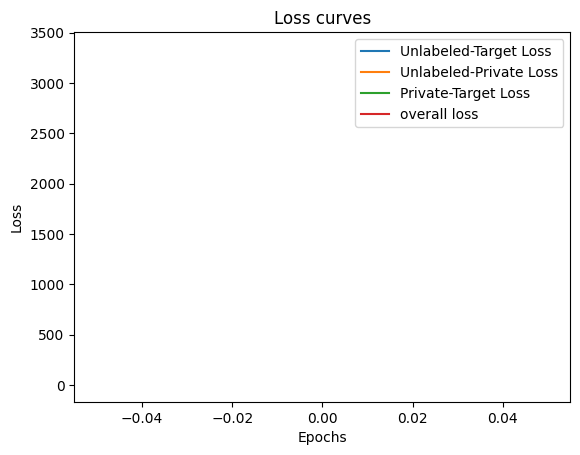

Loss unlabeled-target: 1299.2939453125, Loss unlabeled-private: 1121.648193359375, Loss private-target: 1106.95361328125
Epoch 2, Average Sinkhorn loss: 696.2853393554688
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.004196972120553255, Index: 3279, Label: 0
Weight: 0.004119550343602896, Index: 1356, Label: 8
Weight: 0.003947539255023003, Index: 1016, Label: 8
Weight: 0.003906097263097763, Index: 501, Label: 8
Weight: 0.003541258629411459, Index: 786, Label: 8
Weight: 0.0035140616819262505, Index: 2966, Label: 8
Weight: 0.003460539970546961, Index: 3680, Label: 8
Weight: 0.0034518269822001457, Index: 2771, Label: 8
Weight: 0.0034332238137722015, Index: 2201, Label: 8
Weight: 0.0034183519892394543, Index: 271, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.03148873150348663, Index: 3135, Label: 2
Weight: 0.031120628118515015, Index: 3826, Label: 7
Weight: 0.031037330627441406, Index: 2163, Label: 4
Weight: 0.030847

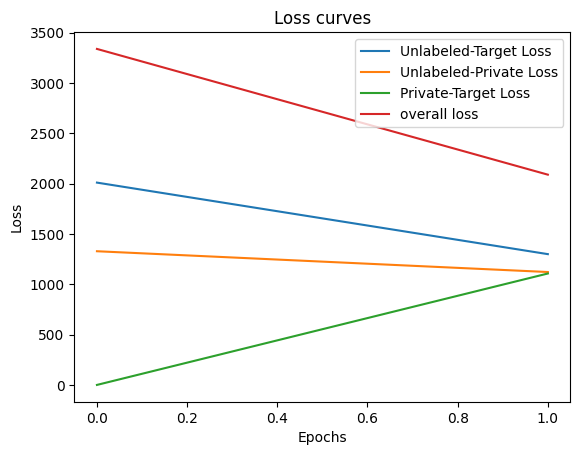

Loss unlabeled-target: 1000.7698974609375, Loss unlabeled-private: 1994.150634765625, Loss private-target: 3733.45751953125
Epoch 3, Average Sinkhorn loss: 624.9609985351562
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.014214987866580486, Index: 1008, Label: 6
Weight: 0.011463782750070095, Index: 454, Label: 6
Weight: 0.011121675372123718, Index: 447, Label: 6
Weight: 0.011038028635084629, Index: 169, Label: 6
Weight: 0.008060571737587452, Index: 154, Label: 6
Weight: 0.006349046714603901, Index: 1855, Label: 6
Weight: 0.006113782525062561, Index: 1474, Label: 2
Weight: 0.005725173745304346, Index: 1356, Label: 8
Weight: 0.005364423152059317, Index: 418, Label: 8
Weight: 0.005270980764180422, Index: 2966, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.025163717567920685, Index: 2700, Label: 2
Weight: 0.018248826265335083, Index: 3400, Label: 7
Weight: 0.0143284872174263, Index: 3780, Label: 5
Weight: 0.0075169503

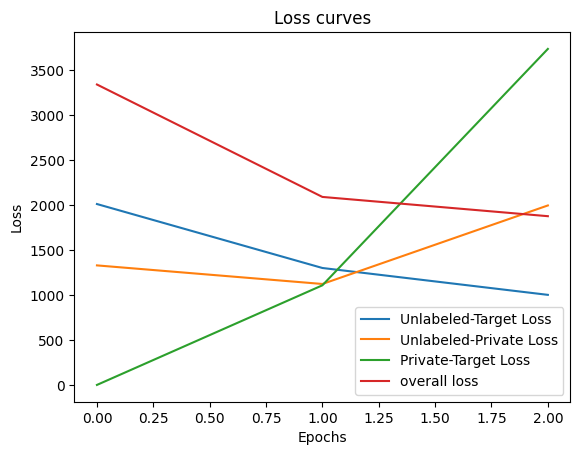

Loss unlabeled-target: 1066.3154296875, Loss unlabeled-private: 1714.60107421875, Loss private-target: 1161.360107421875
Epoch 4, Average Sinkhorn loss: 810.836181640625
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.01410679891705513, Index: 926, Label: 2
Weight: 0.011088989675045013, Index: 3357, Label: 4
Weight: 0.009642462246119976, Index: 2708, Label: 4
Weight: 0.007612475194036961, Index: 2645, Label: 7
Weight: 0.007185005582869053, Index: 2781, Label: 1
Weight: 0.006986744701862335, Index: 2420, Label: 4
Weight: 0.006787003017961979, Index: 3296, Label: 6
Weight: 0.00612550787627697, Index: 407, Label: 4
Weight: 0.0058889565989375114, Index: 1895, Label: 7
Weight: 0.005595664493739605, Index: 1627, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.021859556436538696, Index: 3780, Label: 5
Weight: 0.018669605255126953, Index: 3400, Label: 7
Weight: 0.010653555393218994, Index: 1552, Label: 2
Weight: 0.0105241239

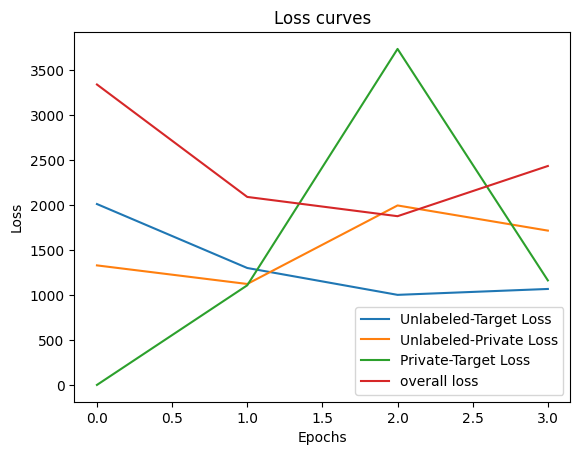

Loss unlabeled-target: 1101.0545654296875, Loss unlabeled-private: 1993.400146484375, Loss private-target: 2656.890380859375
Epoch 5, Average Sinkhorn loss: 765.7958374023438
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.00749563192948699, Index: 926, Label: 2
Weight: 0.00572382053360343, Index: 1356, Label: 8
Weight: 0.005479415878653526, Index: 748, Label: 0
Weight: 0.005412715021520853, Index: 2420, Label: 4
Weight: 0.005321233067661524, Index: 501, Label: 8
Weight: 0.005186470225453377, Index: 3456, Label: 8
Weight: 0.005162486340850592, Index: 3346, Label: 8
Weight: 0.005153842736035585, Index: 1627, Label: 8
Weight: 0.005086518824100494, Index: 3357, Label: 4
Weight: 0.0050692446529865265, Index: 2966, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.018998276442289352, Index: 3400, Label: 7
Weight: 0.01867542415857315, Index: 3780, Label: 5
Weight: 0.010832102969288826, Index: 2700, Label: 2
Weight: 0.0067134

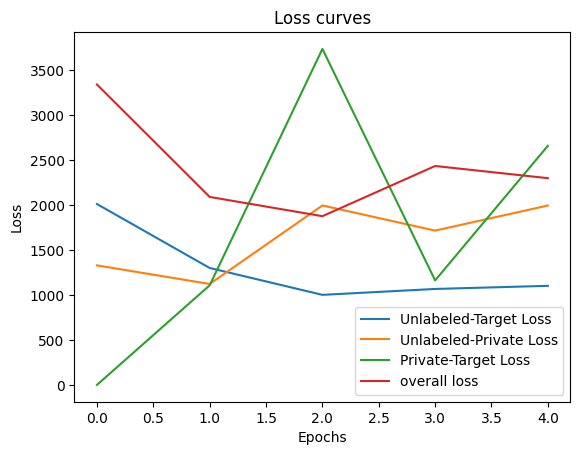

Loss unlabeled-target: 1062.8486328125, Loss unlabeled-private: 1580.882080078125, Loss private-target: 967.1884765625
Epoch 6, Average Sinkhorn loss: 784.5247192382812
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.005979419220238924, Index: 1356, Label: 8
Weight: 0.005650173872709274, Index: 748, Label: 0
Weight: 0.005543769337236881, Index: 501, Label: 8
Weight: 0.0054147206246852875, Index: 3346, Label: 8
Weight: 0.005393416155129671, Index: 3456, Label: 8
Weight: 0.005389093421399593, Index: 397, Label: 6
Weight: 0.005306245759129524, Index: 2966, Label: 8
Weight: 0.005254411604255438, Index: 3017, Label: 8
Weight: 0.005248975940048695, Index: 3680, Label: 8
Weight: 0.005240171682089567, Index: 1627, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.02040763571858406, Index: 3780, Label: 5
Weight: 0.02015160769224167, Index: 3400, Label: 7
Weight: 0.010423628613352776, Index: 2700, Label: 2
Weight: 0.007246993482

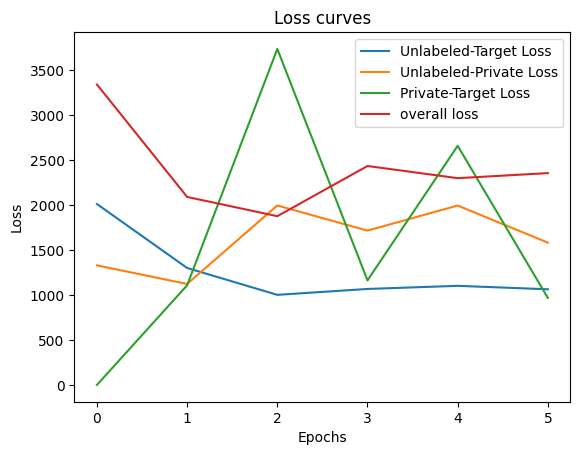

Loss unlabeled-target: 993.5352783203125, Loss unlabeled-private: 1835.340087890625, Loss private-target: 2659.00830078125
Epoch 7, Average Sinkhorn loss: 677.0576782226562
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.0063139586709439754, Index: 1356, Label: 8
Weight: 0.005967306904494762, Index: 748, Label: 0
Weight: 0.005825468804687262, Index: 3346, Label: 8
Weight: 0.005818916019052267, Index: 501, Label: 8
Weight: 0.0056963032111525536, Index: 3456, Label: 8
Weight: 0.005652970168739557, Index: 2966, Label: 8
Weight: 0.005622486583888531, Index: 3017, Label: 8
Weight: 0.005500557366758585, Index: 1016, Label: 8
Weight: 0.0054917484521865845, Index: 418, Label: 8
Weight: 0.005476474761962891, Index: 3680, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.020330069586634636, Index: 3400, Label: 7
Weight: 0.017924536019563675, Index: 3780, Label: 5
Weight: 0.011557859368622303, Index: 2700, Label: 2
Weight: 0.0038

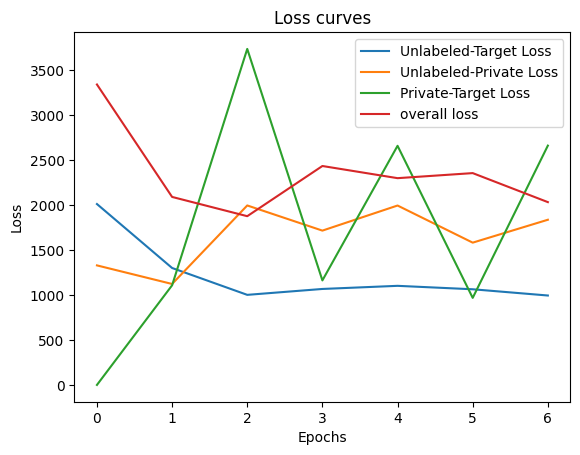

Loss unlabeled-target: 965.9873046875, Loss unlabeled-private: 1831.80615234375, Loss private-target: 754.5713500976562
Epoch 8, Average Sinkhorn loss: 857.1406860351562
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006491255480796099, Index: 1356, Label: 8
Weight: 0.0060844277031719685, Index: 748, Label: 0
Weight: 0.006006729789078236, Index: 3346, Label: 8
Weight: 0.0059715392999351025, Index: 501, Label: 8
Weight: 0.005837616976350546, Index: 3456, Label: 8
Weight: 0.005814886651933193, Index: 2966, Label: 8
Weight: 0.005739477928727865, Index: 3017, Label: 8
Weight: 0.005673982668668032, Index: 3680, Label: 8
Weight: 0.005660508759319782, Index: 1016, Label: 8
Weight: 0.005616897251456976, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.021010590717196465, Index: 3400, Label: 7
Weight: 0.020194264128804207, Index: 3780, Label: 5
Weight: 0.011695865541696548, Index: 2700, Label: 2
Weight: 0.00580220

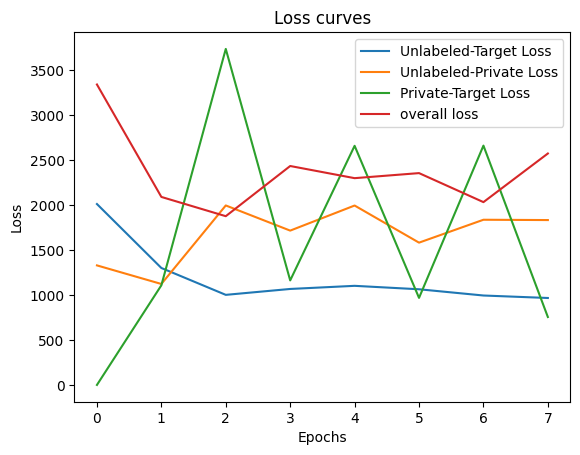

Loss unlabeled-target: 979.16162109375, Loss unlabeled-private: 1811.8150634765625, Loss private-target: 2653.2890625
Epoch 9, Average Sinkhorn loss: 664.99658203125
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006523530930280685, Index: 1356, Label: 8
Weight: 0.006117382552474737, Index: 748, Label: 0
Weight: 0.006046324502676725, Index: 3346, Label: 8
Weight: 0.005997901316732168, Index: 501, Label: 8
Weight: 0.00586932385340333, Index: 3456, Label: 8
Weight: 0.005848995875567198, Index: 2966, Label: 8
Weight: 0.005775490775704384, Index: 3017, Label: 8
Weight: 0.0056969537399709225, Index: 3680, Label: 8
Weight: 0.005689013749361038, Index: 1016, Label: 8
Weight: 0.005651608109474182, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.021068913862109184, Index: 3400, Label: 7
Weight: 0.020020954310894012, Index: 3780, Label: 5
Weight: 0.011815989390015602, Index: 2700, Label: 2
Weight: 0.00564500130712

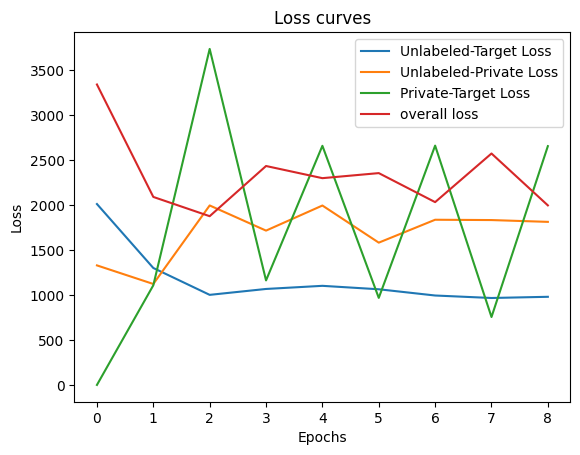

Loss unlabeled-target: 943.574462890625, Loss unlabeled-private: 1426.28662109375, Loss private-target: 2058.589599609375
Epoch 10, Average Sinkhorn loss: 584.0947265625
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006548399105668068, Index: 1356, Label: 8
Weight: 0.006140551064163446, Index: 748, Label: 0
Weight: 0.00607320386916399, Index: 3346, Label: 8
Weight: 0.006021380890160799, Index: 501, Label: 8
Weight: 0.005891682114452124, Index: 3456, Label: 8
Weight: 0.005875238683074713, Index: 2966, Label: 8
Weight: 0.005799031816422939, Index: 3017, Label: 8
Weight: 0.005719302222132683, Index: 3680, Label: 8
Weight: 0.00571348937228322, Index: 1016, Label: 8
Weight: 0.0056751021184027195, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.020997563377022743, Index: 3400, Label: 7
Weight: 0.02007177099585533, Index: 3780, Label: 5
Weight: 0.011896265670657158, Index: 2700, Label: 2
Weight: 0.005687290802

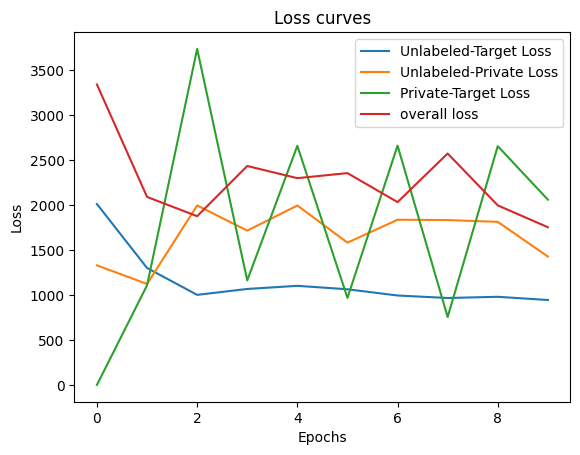

Loss unlabeled-target: 923.050048828125, Loss unlabeled-private: 1430.6568603515625, Loss private-target: 2287.0166015625
Epoch 11, Average Sinkhorn loss: 555.8673706054688
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006571031641215086, Index: 1356, Label: 8
Weight: 0.006161903962492943, Index: 748, Label: 0
Weight: 0.006103917025029659, Index: 3346, Label: 8
Weight: 0.00604304438456893, Index: 501, Label: 8
Weight: 0.005913042929023504, Index: 3456, Label: 8
Weight: 0.005900344345718622, Index: 2966, Label: 8
Weight: 0.005821209400892258, Index: 3017, Label: 8
Weight: 0.005739848129451275, Index: 3680, Label: 8
Weight: 0.0057358997873961926, Index: 1016, Label: 8
Weight: 0.0056964075192809105, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.02092347852885723, Index: 3400, Label: 7
Weight: 0.020120205357670784, Index: 3780, Label: 5
Weight: 0.012000312097370625, Index: 2700, Label: 2
Weight: 0.0057322

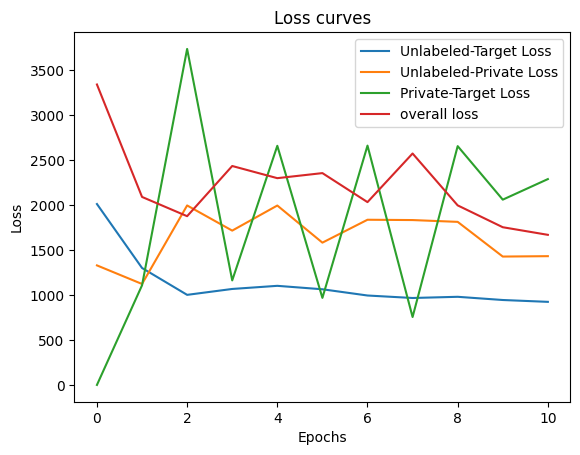

Loss unlabeled-target: 912.1292114257812, Loss unlabeled-private: 1400.986572265625, Loss private-target: 2362.96484375
Epoch 12, Average Sinkhorn loss: 534.7421264648438
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006591521669179201, Index: 1356, Label: 8
Weight: 0.006181853357702494, Index: 748, Label: 0
Weight: 0.006132867652922869, Index: 3346, Label: 8
Weight: 0.006062700878828764, Index: 501, Label: 8
Weight: 0.005933060776442289, Index: 3456, Label: 8
Weight: 0.005924565251916647, Index: 2966, Label: 8
Weight: 0.005841725040227175, Index: 3017, Label: 8
Weight: 0.005758541636168957, Index: 3680, Label: 8
Weight: 0.005756558384746313, Index: 1016, Label: 8
Weight: 0.005715461913496256, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.02082785777747631, Index: 3400, Label: 7
Weight: 0.020165521651506424, Index: 3780, Label: 5
Weight: 0.012074979022145271, Index: 2700, Label: 2
Weight: 0.0057578934

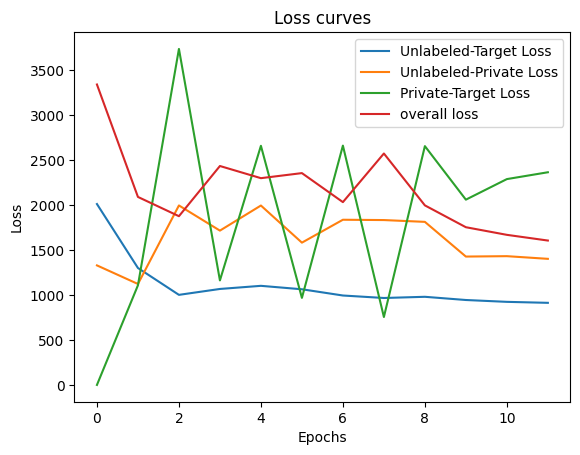

Loss unlabeled-target: 905.4363403320312, Loss unlabeled-private: 1379.458740234375, Loss private-target: 2413.95849609375
Epoch 13, Average Sinkhorn loss: 520.23583984375
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006593444850295782, Index: 1356, Label: 8
Weight: 0.00618424266576767, Index: 748, Label: 0
Weight: 0.006135694682598114, Index: 3346, Label: 8
Weight: 0.006064531859010458, Index: 501, Label: 8
Weight: 0.0059349811635911465, Index: 3456, Label: 8
Weight: 0.005926943384110928, Index: 2966, Label: 8
Weight: 0.005843648687005043, Index: 3017, Label: 8
Weight: 0.0057602617889642715, Index: 3680, Label: 8
Weight: 0.005758501589298248, Index: 1016, Label: 8
Weight: 0.00571728078648448, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.02081742323935032, Index: 3400, Label: 7
Weight: 0.020170262083411217, Index: 3780, Label: 5
Weight: 0.012081209570169449, Index: 2700, Label: 2
Weight: 0.005759754

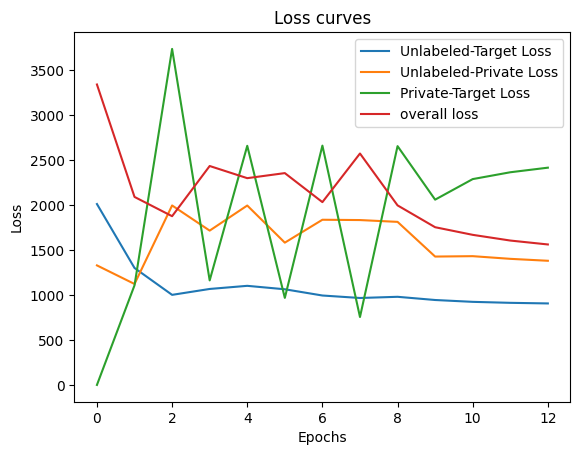

Loss unlabeled-target: 904.8289184570312, Loss unlabeled-private: 1377.214599609375, Loss private-target: 2420.58349609375
Epoch 14, Average Sinkhorn loss: 518.622802734375
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006595358718186617, Index: 1356, Label: 8
Weight: 0.006186624523252249, Index: 748, Label: 0
Weight: 0.006138508673757315, Index: 3346, Label: 8
Weight: 0.006066353525966406, Index: 501, Label: 8
Weight: 0.0059369029477238655, Index: 3456, Label: 8
Weight: 0.005929313134402037, Index: 2966, Label: 8
Weight: 0.005845564883202314, Index: 3017, Label: 8
Weight: 0.005761994980275631, Index: 3680, Label: 8
Weight: 0.005760436877608299, Index: 1016, Label: 8
Weight: 0.005719037726521492, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.02080739662051201, Index: 3400, Label: 7
Weight: 0.020175335928797722, Index: 3780, Label: 5
Weight: 0.012087765149772167, Index: 2700, Label: 2
Weight: 0.0057619

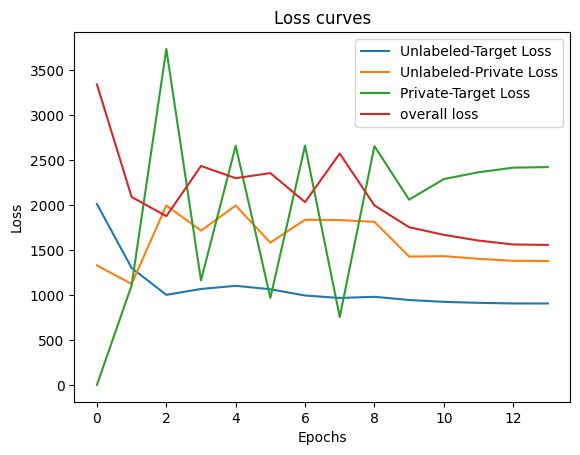

Loss unlabeled-target: 904.5210571289062, Loss unlabeled-private: 1375.4681396484375, Loss private-target: 2428.11181640625
Epoch 15, Average Sinkhorn loss: 517.1852416992188
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006597249768674374, Index: 1356, Label: 8
Weight: 0.006188985891640186, Index: 748, Label: 0
Weight: 0.006141311023384333, Index: 3346, Label: 8
Weight: 0.00606815330684185, Index: 501, Label: 8
Weight: 0.0059388005174696445, Index: 3456, Label: 8
Weight: 0.005931666120886803, Index: 2966, Label: 8
Weight: 0.005847464315593243, Index: 3017, Label: 8
Weight: 0.005763690453022718, Index: 3680, Label: 8
Weight: 0.005762350745499134, Index: 1016, Label: 8
Weight: 0.0057208179496228695, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.02079688385128975, Index: 3400, Label: 7
Weight: 0.02017998695373535, Index: 3780, Label: 5
Weight: 0.012093747965991497, Index: 2700, Label: 2
Weight: 0.005763

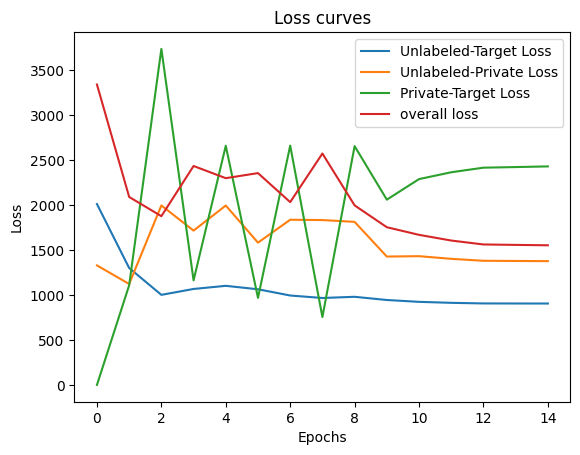

Loss unlabeled-target: 903.99072265625, Loss unlabeled-private: 1373.399658203125, Loss private-target: 2431.607666015625
Epoch 16, Average Sinkhorn loss: 515.9693603515625
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.00659913569688797, Index: 1356, Label: 8
Weight: 0.006191346328705549, Index: 748, Label: 0
Weight: 0.006144104991108179, Index: 3346, Label: 8
Weight: 0.006069947965443134, Index: 501, Label: 8
Weight: 0.005940702743828297, Index: 3456, Label: 8
Weight: 0.005934014450758696, Index: 2966, Label: 8
Weight: 0.005849361419677734, Index: 3017, Label: 8
Weight: 0.005765397567301989, Index: 3680, Label: 8
Weight: 0.005764261353760958, Index: 1016, Label: 8
Weight: 0.005722545087337494, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.020786400884389877, Index: 3400, Label: 7
Weight: 0.020184732973575592, Index: 3780, Label: 5
Weight: 0.012099679559469223, Index: 2700, Label: 2
Weight: 0.00576546

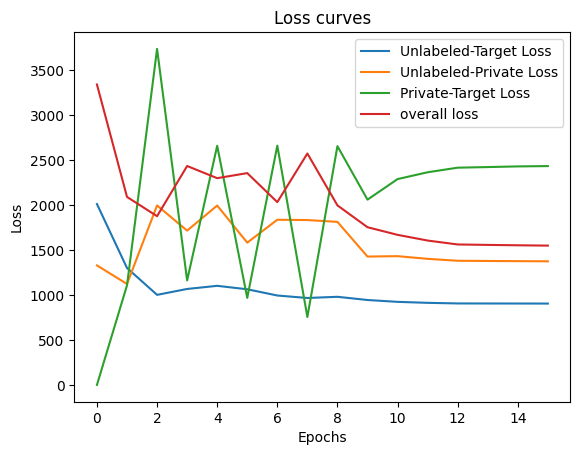

Loss unlabeled-target: 903.83544921875, Loss unlabeled-private: 1371.364501953125, Loss private-target: 2437.13720703125
Epoch 17, Average Sinkhorn loss: 514.686279296875
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.00659932242706418, Index: 1356, Label: 8
Weight: 0.006191580556333065, Index: 748, Label: 0
Weight: 0.006144383456557989, Index: 3346, Label: 8
Weight: 0.0060701253823935986, Index: 501, Label: 8
Weight: 0.005940891336649656, Index: 3456, Label: 8
Weight: 0.005934247747063637, Index: 2966, Label: 8
Weight: 0.005849549081176519, Index: 3017, Label: 8
Weight: 0.005765565205365419, Index: 3680, Label: 8
Weight: 0.005764450877904892, Index: 1016, Label: 8
Weight: 0.005722720641642809, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.020785341039299965, Index: 3400, Label: 7
Weight: 0.020185183733701706, Index: 3780, Label: 5
Weight: 0.012100251391530037, Index: 2700, Label: 2
Weight: 0.005765624

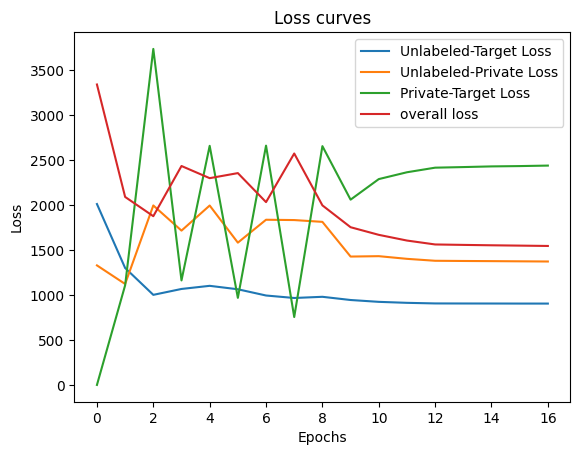

Loss unlabeled-target: 903.7127075195312, Loss unlabeled-private: 1371.0634765625, Loss private-target: 2435.99951171875
Epoch 18, Average Sinkhorn loss: 514.6587524414062
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006599510088562965, Index: 1356, Label: 8
Weight: 0.0061918157152831554, Index: 748, Label: 0
Weight: 0.0061446623876690865, Index: 3346, Label: 8
Weight: 0.006070303730666637, Index: 501, Label: 8
Weight: 0.0059410808607935905, Index: 3456, Label: 8
Weight: 0.005934481974691153, Index: 2966, Label: 8
Weight: 0.005849737673997879, Index: 3017, Label: 8
Weight: 0.005765734706073999, Index: 3680, Label: 8
Weight: 0.0057646408677101135, Index: 1016, Label: 8
Weight: 0.005722892936319113, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.02078431472182274, Index: 3400, Label: 7
Weight: 0.020185664296150208, Index: 3780, Label: 5
Weight: 0.012100852094590664, Index: 2700, Label: 2
Weight: 0.00576

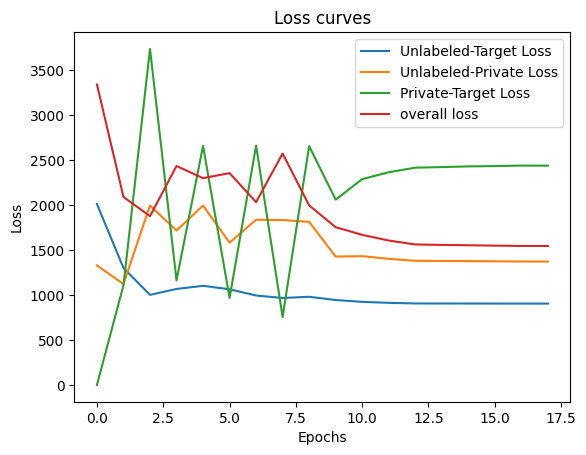

Loss unlabeled-target: 903.7940063476562, Loss unlabeled-private: 1371.003173828125, Loss private-target: 2439.00439453125
Epoch 19, Average Sinkhorn loss: 514.365234375
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.0065996963530778885, Index: 1356, Label: 8
Weight: 0.006192049477249384, Index: 748, Label: 0
Weight: 0.006144940387457609, Index: 3346, Label: 8
Weight: 0.006070481147617102, Index: 501, Label: 8
Weight: 0.005941268987953663, Index: 3456, Label: 8
Weight: 0.005934715270996094, Index: 2966, Label: 8
Weight: 0.005849925335496664, Index: 3017, Label: 8
Weight: 0.005765901878476143, Index: 3680, Label: 8
Weight: 0.0057648299261927605, Index: 1016, Label: 8
Weight: 0.0057230680249631405, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.02078326977789402, Index: 3400, Label: 7
Weight: 0.02018612064421177, Index: 3780, Label: 5
Weight: 0.012101424857974052, Index: 2700, Label: 2
Weight: 0.005765972

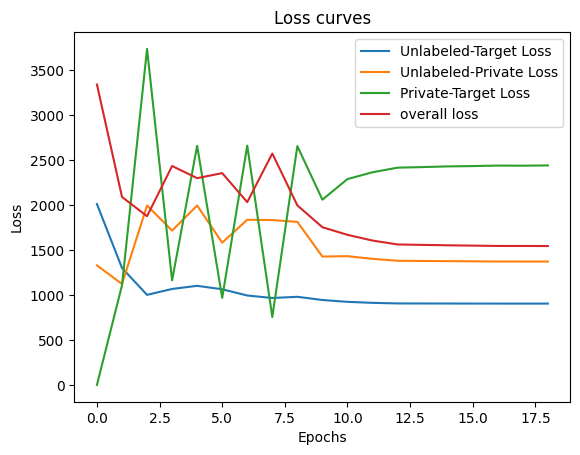

Loss unlabeled-target: 903.65234375, Loss unlabeled-private: 1370.6968994140625, Loss private-target: 2438.188720703125
Epoch 20, Average Sinkhorn loss: 514.2974853515625
Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006599883083254099, Index: 1356, Label: 8
Weight: 0.006192284170538187, Index: 748, Label: 0
Weight: 0.006145218852907419, Index: 3346, Label: 8
Weight: 0.006070659030228853, Index: 501, Label: 8
Weight: 0.00594145804643631, Index: 3456, Label: 8
Weight: 0.005934949032962322, Index: 2966, Label: 8
Weight: 0.005850113462656736, Index: 3017, Label: 8
Weight: 0.005766070913523436, Index: 3680, Label: 8
Weight: 0.005765019450336695, Index: 1016, Label: 8
Weight: 0.005723239853978157, Index: 418, Label: 8
Top 10 weights for private, their indices, and corresponding labels:
Weight: 0.02078225091099739, Index: 3400, Label: 7
Weight: 0.02018659934401512, Index: 3780, Label: 5
Weight: 0.012102018110454082, Index: 2700, Label: 2
Weight: 0.005766155663

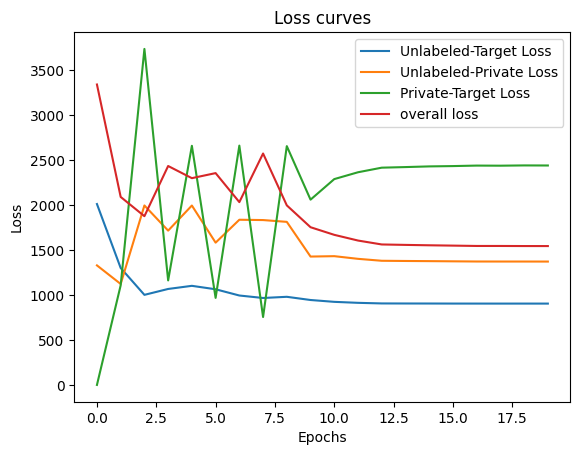

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from geomloss import SamplesLoss
from torch import optim
from torchvision.datasets import CIFAR10
import random
from torchvision.models import resnet50, resnet18

# Define a function to project weights to a simplex
def project_simplex(v):
    z = 1
    orig_shape = v.shape
    v = v.view(1, -1)
    shape = v.shape
    with torch.no_grad():
        mu = torch.sort(v, dim=1)[0]
        mu = torch.flip(mu, dims=(1,))
        cum_sum = torch.cumsum(mu, dim=1)
        j = torch.unsqueeze(torch.arange(1, shape[1] + 1, dtype=mu.dtype, device=mu.device), 0)
        rho = torch.sum(mu * j - cum_sum + z > 0.0, dim=1, keepdim=True) - 1.
        rho = rho.to(int)
        max_nn = cum_sum[torch.arange(shape[0]), rho[:, 0]]
        theta = (torch.unsqueeze(max_nn, -1) - z) / (rho.type(max_nn.dtype) + 1)
        w = torch.clamp(v - theta, min=0.0).view(orig_shape)
        return w

transform = transforms.Compose(
    [
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
# Get the whole CIFAR10 dataset
cifar_trainset = CIFAR10(root='data/', download=True, transform=transform)

# Split the whole CIFAR10 dataset based on class labels into ten subsets
class_datasets = [[] for _ in range(10)]
for image, label in cifar_trainset:
    class_datasets[label].append((image, label))

target_size = 100
print('target and private datasets size is:',target_size)
# For the target dataset, pick 100 samples from one class
target_class = 8
target_dataset = class_datasets[target_class][:target_size]
class_datasets[target_class] = class_datasets[target_class][target_size:]

# For the private dataset, pick 10 samples each from the remaining 9 classes
private_size = 10
private_dataset = []
for class_num, class_dataset in enumerate(class_datasets):
    if class_num != target_class:
        private_dataset.extend(class_dataset[:private_size])
        class_datasets[class_num] = class_dataset[private_size:]



# The unlabeled dataset will contain the remaining samples
unlabeled_dataset = [(image, label) for class_dataset in class_datasets for image, label in class_dataset]


# Shuffle the datasets
random.shuffle(unlabeled_dataset)
random.shuffle(private_dataset)
random.shuffle(target_dataset)
# Get the labels for the unlabeled dataset
unlabeled_labels = [label for _, label in unlabeled_dataset]
unlabeled_size = 10000
print('unlabeled dataset size is:',unlabeled_size)

# Create DataLoaders for each dataset
unlabeled_loader = DataLoader(unlabeled_dataset[:unlabeled_size], batch_size=4000, shuffle=False)
target_loader = DataLoader(target_dataset, batch_size=len(target_dataset), shuffle=False)
private_loader = DataLoader(private_dataset, batch_size=len(private_dataset), shuffle=False)

# Load the pretrained ResNet18 model
model = resnet18(pretrained=True)

# Set the model to evaluation mode
model.eval()


# Create a loss function using GeomLoss
sinkhorn_loss = SamplesLoss(loss="sinkhorn", p=2, blur=0.1)

# Initialize weights for the unlabeled_images for target and private
weights_unlabeled_target = torch.full((len(unlabeled_dataset), 1), 1.0 / len(unlabeled_dataset), requires_grad=True)
weights_unlabeled_private = torch.full((len(unlabeled_dataset), 1), 1.0 / len(unlabeled_dataset), requires_grad=True)
weights_target = torch.full((len(target_dataset), 1), 1.0 / len(target_dataset), requires_grad=False)
weights_private = torch.full((len(private_dataset), 1), 1.0 / len(private_dataset), requires_grad=False)

# Define an optimizer for each set of weights
optimizer_target = optim.Adagrad([weights_unlabeled_target], lr=.1)
optimizer_private = optim.Adagrad([weights_unlabeled_private], lr=.1)

# Define the learning rate scheduler
scheduler_target = torch.optim.lr_scheduler.StepLR(optimizer_target, step_size=4, gamma=0.1)
scheduler_private = torch.optim.lr_scheduler.StepLR(optimizer_private, step_size=4, gamma=0.1)

# Create lists to store the loss values
loss_values_unlabeled_target = []
loss_values_unlabeled_private = []
loss_values_private_target = []
overall_loss=[]



# Loop over the datasets 10 times
for epoch in range(20):

    losses = []
    weights_unlabeled_target.grad = None  # Reset gradients at the beginning of each epoch
    weights_unlabeled_private.grad = None  # Reset gradients at the beginning of each epoch

   # Initialize loss_avg as a tensor with requires_grad=True
    loss_avg = torch.tensor(0.0, requires_grad=True)
    
    for batch_idx, batch in enumerate(zip(unlabeled_loader, target_loader, private_loader)):
        unlabeled_images, _ = batch[0]
        target_images, _ = batch[1]
        private_images, _ = batch[2]
         # Don't calculate gradients
        with torch.no_grad():
            # Get the features using the pretrained model
            unlabeled_features = model(unlabeled_images)
            target_features = model(target_images)
            private_features = model(private_images)

        optimizer_target.zero_grad()  # Reset gradients
        optimizer_private.zero_grad()  # Reset gradients

        # Select the weights for the current batch
        unlabeled_images = unlabeled_images[:,0,:,:]
        target_images = target_images[:,0,:,:]
        private_images = private_images[:,0,:,:]
        weights_batch_target = weights_unlabeled_target[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_target = weights_batch_target.clone() / weights_batch_target.sum()
        weights_batch_private = weights_unlabeled_private[batch_idx * unlabeled_loader.batch_size : (batch_idx + 1) * unlabeled_loader.batch_size]
        weights_batch_private = weights_batch_private.clone() / weights_batch_private.sum()

        # Reshape the images to be 1D tensors
        unlabeled_images = unlabeled_images.view(unlabeled_images.shape[0], -1)
        target_images = target_images.view(target_images.shape[0], -1)
        private_images = private_images.view(private_images.shape[0], -1)

        # Flatten the features to be 1D tensors
        unlabeled_features = unlabeled_features.view(unlabeled_features.shape[0], -1)
        target_features = target_features.view(target_features.shape[0], -1)
        private_features = private_features.view(private_features.shape[0], -1)


      
        # Compute Sinkhorn loss
        loss_unlabeled_target = sinkhorn_loss(weights_batch_target, unlabeled_features, weights_target, target_features)
        loss_unlabeled_private = sinkhorn_loss(weights_batch_private, unlabeled_features, weights_private, private_features)
        loss_private_target = sinkhorn_loss(weights_batch_target, unlabeled_features, weights_batch_private, unlabeled_features)

        loss_values_unlabeled_target.append(loss_unlabeled_target.item())
        loss_values_unlabeled_private.append(loss_unlabeled_private.item())
        loss_values_private_target.append(loss_private_target.item())


        loss = loss_unlabeled_target + loss_unlabeled_private - 0.3*loss_private_target
        overall_loss.append(loss.item())
        print(f"Loss unlabeled-target: {loss_unlabeled_target.item()}, Loss unlabeled-private: {loss_unlabeled_private.item()}, Loss private-target: {loss_private_target.item()}")
        # Accumulate loss into loss_avg
        loss_avg = loss_avg + loss / len(unlabeled_loader)

       

        
       
    # Average the loss over all mini-batches
    loss_avg.backward()
   
    # Update the weights based on the accumulated gradients
    optimizer_target.step()
    optimizer_private.step()

    # Step the learning rate scheduler
    scheduler_target.step()
    scheduler_private.step()
    
   
    
    


    # Project the weights to a simplex
    with torch.no_grad():
        weights_unlabeled_target.data = project_simplex(weights_unlabeled_target.data)
        weights_unlabeled_private.data = project_simplex(weights_unlabeled_private.data)

    print(f"Epoch {epoch+1}, Average Sinkhorn loss: {loss_avg}")

    # Sort the weights in descending order and print the non-zero weights
    sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
    top_weights_target = sorted_weights_target[:10]
    top_indices_target = indices_target[:10]

    sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
    top_weights_private = sorted_weights_private[:10]
    top_indices_private = indices_private[:10]

    # Retrieve the labels of the images corresponding to the top indices
    top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
    top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

    print("Top 10 weights for target, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

    print("Top 10 weights for private, their indices, and corresponding labels:")
    for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
        print(f"Weight: {weight}, Index: {idx}, Label: {label}")

    import matplotlib.pyplot as plt

    # Create a figure and a set of subplots
    fig, ax = plt.subplots()

    # Plot the loss values
    ax.plot(loss_values_unlabeled_target, label='Unlabeled-Target Loss')
    ax.plot(loss_values_unlabeled_private, label='Unlabeled-Private Loss')
    ax.plot(loss_values_private_target, label='Private-Target Loss')
    ax.plot(overall_loss,label='overall loss')
    # Set the labels and title
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Loss curves')

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()



In [11]:
# Sort the weights in descending order and print the non-zero weights
sorted_weights_target, indices_target = torch.sort(weights_unlabeled_target.flatten(), descending=True)
top_weights_target = sorted_weights_target[:50]
top_indices_target = indices_target[:50]

sorted_weights_private, indices_private = torch.sort(weights_unlabeled_private.flatten(), descending=True)
top_weights_private = sorted_weights_private[:10]
top_indices_private = indices_private[:10]

# Retrieve the labels of the images corresponding to the top indices
top_labels_target = [unlabeled_labels[idx] for idx in top_indices_target]
top_labels_private = [unlabeled_labels[idx] for idx in top_indices_private]

print("Top 10 weights for target, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights_target, top_indices_target, top_labels_target):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")

print("Top 10 weights for private, their indices, and corresponding labels:")
for weight, idx, label in zip(top_weights_private, top_indices_private, top_labels_private):
    print(f"Weight: {weight}, Index: {idx}, Label: {label}")


Top 10 weights for target, their indices, and corresponding labels:
Weight: 0.006599883083254099, Index: 1356, Label: 8
Weight: 0.006192284170538187, Index: 748, Label: 0
Weight: 0.006145218852907419, Index: 3346, Label: 8
Weight: 0.006070659030228853, Index: 501, Label: 8
Weight: 0.00594145804643631, Index: 3456, Label: 8
Weight: 0.005934949032962322, Index: 2966, Label: 8
Weight: 0.005850113462656736, Index: 3017, Label: 8
Weight: 0.005766070913523436, Index: 3680, Label: 8
Weight: 0.005765019450336695, Index: 1016, Label: 8
Weight: 0.005723239853978157, Index: 418, Label: 8
Weight: 0.005712035112082958, Index: 1248, Label: 8
Weight: 0.0055363792926073074, Index: 560, Label: 8
Weight: 0.005471163894981146, Index: 593, Label: 8
Weight: 0.005420262459665537, Index: 1482, Label: 8
Weight: 0.005315500311553478, Index: 309, Label: 8
Weight: 0.00510141858831048, Index: 635, Label: 8
Weight: 0.005041082389652729, Index: 1627, Label: 8
Weight: 0.004883664194494486, Index: 1054, Label: 8
Weig